In [1]:
!pip install torch-summary torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [2]:
from datasets import load_dataset, DatasetDict
from PIL import Image
import torch
from torchvision import transforms
from transformers import ViTModel, TrainingArguments, Trainer
from torch import nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from safetensors.torch import load_file as safetensors_load_file
from huggingface_hub import create_repo, HfApi
import logging
import os
import json
import shutil
import csv

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

2024-08-03 00:41:29.859582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 00:41:29.859722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 00:41:29.983354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tqdm.notebook import tqdm
import pandas as pd

BASE_PATH = '/kaggle/input/scut-fbp5500-v2-facial-beauty-scores'
data = []
with open(f'{BASE_PATH}/labels.txt', 'r', encoding='utf-8') as labels_file:
    labels = labels_file.readlines()
    for label in tqdm(labels):
        row = label.rstrip('\n').split(' ')
        data.append(row)

df = pd.DataFrame(data, columns=['Filename', 'Beauty Rate'])

  0%|          | 0/5500 [00:00<?, ?it/s]

In [4]:
df.head()

,Filename,Beauty Rate
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.15
3,AM1774.jpg,3.75
4,CF215.jpg,3.033333


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os
from PIL import Image

class BeautyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        filename, label = self.df.iloc[idx].values
        img_path = os.path.join(self.img_dir, filename)
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(float(label), dtype=torch.float32)

In [6]:
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

ds = BeautyDataset(df, f'{BASE_PATH}/Images/Images', transform=transform)

val_size = 0.2
indices = list(range(len(df)))
np.random.shuffle(indices)
split = int(np.floor(val_size * len(df)))
train_indices, val_indices = indices[split:], indices[:split]


train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [7]:
class BeautyCNN(nn.Module):
    def __init__(self):
        super(BeautyCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        return x

In [8]:
class ViTCNN(nn.Module):
    def __init__(self):
        super(ViTCNN, self).__init__()
        self.vit = ViTModel.from_pretrained('trpakov/vit-face-expression')
        self.fc_vit = nn.Linear(self.vit.config.hidden_size, 256)
        self.fc_vit_dropout = nn.Dropout(0.2)
        
        self.cnn_model = BeautyCNN()
        self.fc_cnn = nn.Linear(64 * 14 * 14, 256)
        self.fc_cnn_dropout = nn.Dropout(0.2)
        
        self.fc_dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256 * 2, 1)

    def forward(self, pixel_values, labels=None):
        # Run ViT and CNN models in parallel
        vit_future = torch.jit.fork(self._process_vit, pixel_values)
        cnn_future = torch.jit.fork(self._process_cnn, pixel_values)
        
        # Wait for the results
        x1 = torch.jit.wait(vit_future)
        x2 = torch.jit.wait(cnn_future)
        
        # Concatenate results and pass through final layers
        x = torch.cat((x1, x2), dim=1)
        values = self.fc2(x)
        
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(values.view(-1), labels.view(-1))
        return (loss, values) if loss is not None else values

    def _process_vit(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token
        x1 = self.fc_vit(cls_output)
        x1 = self.fc_vit_dropout(x1)
        return x1

    def _process_cnn(self, pixel_values):
        x2 = self.cnn_model(pixel_values)
        x2 = self.fc_cnn(x2)
        x2 = self.fc_cnn_dropout(x2)
        return x2

In [9]:
model = ViTCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3,224,224))

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at trpakov/vit-face-expression and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                   Output Shape              Param #
├─ViTModel: 1-1                          [[-1, 768]]               --
|    └─ViTEmbeddings: 2-1                [-1, 197, 768]            --
|    |    └─ViTPatchEmbeddings: 3-1      [-1, 196, 768]            590,592
|    |    └─Dropout: 3-2                 [-1, 197, 768]            --
|    └─ViTEncoder: 2-2                   [[-1, 197, 768]]          --
|    └─LayerNorm: 2-3                    [-1, 197, 768]            1,536
|    └─ViTPooler: 2-4                    [-1, 768]                 --
|    |    └─Linear: 3-3                  [-1, 768]                 590,592
|    |    └─Tanh: 3-4                    [-1, 768]                 --
├─Linear: 1-2                            [-1, 256]                 196,864
├─Dropout: 1-3                           [-1, 256]                 --
├─BeautyCNN: 1-4                         [-1, 12544]               --
|    └─Sequential: 2-5                   [-1, 16, 112, 112]        

Layer (type:depth-idx)                   Output Shape              Param #
├─ViTModel: 1-1                          [[-1, 768]]               --
|    └─ViTEmbeddings: 2-1                [-1, 197, 768]            --
|    |    └─ViTPatchEmbeddings: 3-1      [-1, 196, 768]            590,592
|    |    └─Dropout: 3-2                 [-1, 197, 768]            --
|    └─ViTEncoder: 2-2                   [[-1, 197, 768]]          --
|    └─LayerNorm: 2-3                    [-1, 197, 768]            1,536
|    └─ViTPooler: 2-4                    [-1, 768]                 --
|    |    └─Linear: 3-3                  [-1, 768]                 590,592
|    |    └─Tanh: 3-4                    [-1, 768]                 --
├─Linear: 1-2                            [-1, 256]                 196,864
├─Dropout: 1-3                           [-1, 256]                 --
├─BeautyCNN: 1-4                         [-1, 12544]               --
|    └─Sequential: 2-5                   [-1, 16, 112, 112]        

In [10]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        self.patience = patience 
        self.delta = delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

train_loss = []
validation_loss = []
early_stopping = EarlyStopping(patience=7, verbose=True, path='beautycnn.weight')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).to(device)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).to(device)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    validation_loss.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Check for early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping ...")
        break

In [12]:
# Pop the first epoch for better visualization
train_loss.pop(0)
validation_loss.pop(0)

0.4127020950750871

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training loss values
ax.plot(train_loss, marker='o', label='Training Loss')

# Plot the validation loss values
ax.plot(validation_loss, marker='x', label='Validation Loss')

# Set the title and labels
ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')

# Add a legend
ax.legend()

# Show the plot
plt.show()

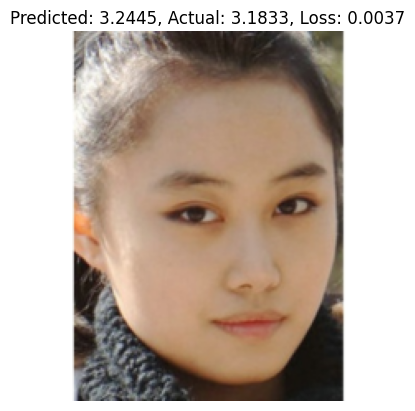

In [15]:
# Demo of the model on validation set.

index = 1
# Get the image and label
images, labels = next(iter(val_loader))
image = images[index]
label = labels[index]

image = image.unsqueeze(0)


# Move the image and the model to the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model = model.to(device)

with torch.no_grad():
    output = model(image).to(device)
    
# Assuming a regression task, use MSELoss
loss = criterion(output, label.unsqueeze(0).to(device))

# Display the image and prediction
image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.title(f"Predicted: {output.item():.4f}, Actual: {label.item():.4f}, Loss: {loss.item():.4f}")
plt.axis('off')
plt.show()

In [17]:
# Load the best model
model = ViTCNN()
model.load_state_dict(torch.load('beautycnn.weight', map_location=torch.device(device)))
model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at trpakov/vit-face-expression and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTCNN(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [22]:
device = torch.device("cpu")

In [23]:
from torcheval.metrics import R2Score
all_preds = []
all_labels = []
val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)
        all_preds.extend(outputs.squeeze())
        all_labels.extend(labels)
        
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item() * images.size(0)

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)
val_loss /= len(val_loader.dataset)
print(f'MSE validation Loss: {val_loss:.4f}')

## R Squared
r2score_metric = R2Score()
r2score_metric.update(all_preds, all_labels)
r_squared = r2score_metric.compute()
print(f'R Squared validation Loss: {r_squared:.4f}')

## MAE Loss
MAE = nn.L1Loss() 
mae_score = MAE(all_preds, all_labels) 

print("MAE validation loss: ", mae_score)

MSE validation Loss: 0.1791
R Squared validation Loss: 0.6018
MAE validation loss:  tensor(0.3204)
